# Kernels and hyperparameters



This tutorial is an introduction to the syntax used by the optimizer, as well as the principles of Bayesian optimization in general.

We'll start by minimizing Booth's function, which looks like this:

Text(0, 0.5, 'x2')

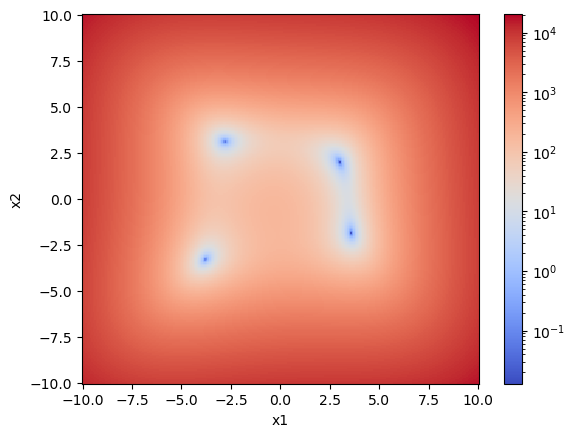

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bloptools

x1 = x2 = np.linspace(-10, 10, 256)
X1, X2 = np.meshgrid(x1, x2)

plt.pcolormesh(x1, x2, bloptools.experiments.tests.himmelblau(X1, X2), norm=mpl.colors.LogNorm(), shading="auto")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")


There are several things that our agent will need. The first ingredient is some degrees of freedom (these are always `ophyd` devices) which the agent will move around to different inputs within each DOF's bounds (the second ingredient). We define these here:

In [2]:
import bloptools

dofs = bloptools.experiments.tests.get_dummy_dofs(2)
bounds = [(-10, 10), (-10, 10)]

The agent automatically samples at different inputs, but we often need some post-processing after data collection. In this case, we need to give the agent a way to compute Himmelblau's function. We accomplish this with a digestion function:

In [3]:
def digestion(db, uid):

    table = db[uid].table()
    products = {"himmelblau": []}

    for index, entry in table.iterrows():

        products["himmelblau"].append(bloptools.experiments.tests.himmelblau(entry.x1, entry.x2))

    return products

The next ingredient is a task, which gives the agent something to do. We want it to minimize Himmelblau's function, so we make a task that will try to minimize the output of the digestion function called "himmelblau". We also include a transform function, which will make it easier to regress over the outputs of the function.

In [4]:
from bloptools.tasks import Task

task = Task(key="himmelblau", kind="min", transform=lambda x: np.log(1 + 1e-2 * x))

Combining all of these with a databroker instance, we can make an agent:

In [5]:
%run -i ../../../examples/prepare_bluesky.py # prepare the bluesky environment

boa = bloptools.bayesian.Agent(
                                dofs=dofs, # things which we move around
                                bounds=bounds, # where we're allowed to move them
                                tasks=task, # tasks for the optimizer
                                digestion=digestion, # how to process the acquisition into task data
                                db=db, # a databroker instance
                                )

RE(boa.initialize(init_scheme='quasi-random', n_init=16))



Transient Scan ID: 1     Time: 2023-06-17 19:14:11
Persistent Unique Scan ID: '4c34fcc3-5fa1-486a-9371-7b1c5b75b253'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 


+-----------+------------+------------+------------+
generator list_scan ['4c34fcc3'] (scan num: 1)





('4c34fcc3-5fa1-486a-9371-7b1c5b75b253',)

We initialized the GP with the "quasi-random" strategy, as it doesn't require any prior data. We can view the state of the optimizer's posterior of the tasks over the input parameters:

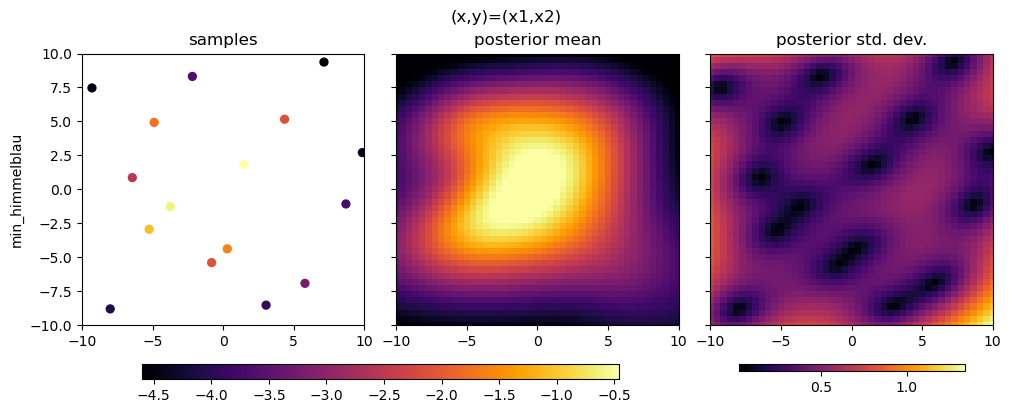

In [6]:
boa.plot_tasks()

We can also the agent's posterior about the probability of goodness over the parameters:

We want to learn a bit more, so we can ask the agent where to sample based off of some strategy. Here we use the "esti" strategy, which maximizes the expected sum of tasks improvement.

We can ask the agent to "route" them using ``ortools``, so that we can sample them more quickly if it requires us to e.g. move motors.

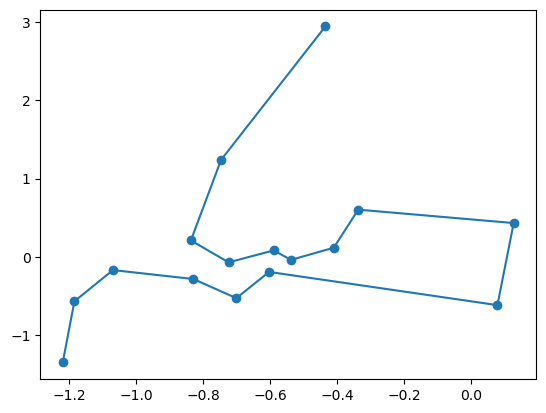

In [7]:
X_to_sample = boa.ask(strategy='esti', n=16, optimize=True, route=True)
plt.scatter(*X_to_sample.T)
plt.plot(*X_to_sample.T)

Let's tell the agent to learn a bit more (it will direct itself):

learning with strategy "esti" ...




Transient Scan ID: 2     Time: 2023-06-17 19:14:22
Persistent Unique Scan ID: '4a0ea918-c0cc-48b1-983d-4be0ed6849b6'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:22.0 |     -0.732 |      0.974 |
|         2 | 19:14:22.0 |      0.217 |      0.321 |
|         3 | 19:14:22.0 |     -0.586 |     -0.314 |
|         4 | 19:14:22.0 |     -1.547 |     -1.457 |
+-----------+------------+------------+------------+
generator list_scan ['4a0ea918'] (scan num: 2)





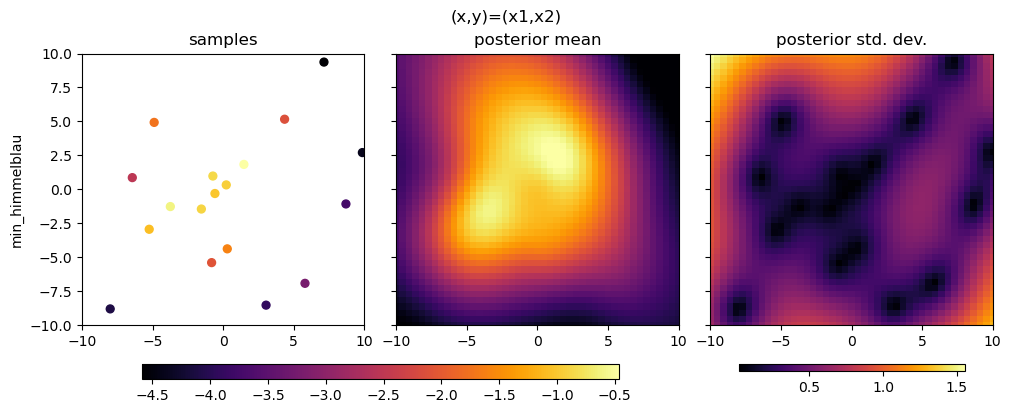

In [8]:
RE(boa.learn(strategy='esti', n_iter=1, n_per_iter=4))
boa.plot_tasks()

The agent has updated its model of the tasks, including refitting the hyperparameters. Continuing:

learning with strategy "esti" ...




Transient Scan ID: 3     Time: 2023-06-17 19:14:25
Persistent Unique Scan ID: 'b504eddd-6c60-409f-83cf-be3d19c691e7'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:25.1 |     -1.765 |      5.832 |
|         2 | 19:14:25.1 |      0.482 |      3.914 |
|         3 | 19:14:25.1 |      1.374 |      2.724 |
|         4 | 19:14:25.1 |      1.315 |     10.000 |
+-----------+------------+------------+------------+
generator list_scan ['b504eddd'] (scan num: 3)







Transient Scan ID: 4     Time: 2023-06-17 19:14:27
Persistent Unique Scan ID: '0d9bc3f7-0d1a-4cd1-9efd-cebd5317220c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:27.1 |      1.955 |      2.439 |
|         2 | 19:14:27.1 |      1.316 |      2.420 |
|         3 | 19:14:27.1 |      0.837 |      2.428 |
|         4 | 19:14:27.1 |     -2.681 |     -2.309 |
+-----------+------------+------------+------------+
generator list_scan ['0d9bc3f7'] (scan num: 4)







Transient Scan ID: 5     Time: 2023-06-17 19:14:29
Persistent Unique Scan ID: 'a19ca511-47f7-421a-9e69-d1e11e7e2e9a'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:29.3 |      2.319 |      2.386 |
|         2 | 19:14:29.3 |      2.573 |      2.378 |
|         3 | 19:14:29.3 |      2.328 |      2.573 |
|         4 | 19:14:29.3 |    -10.000 |     10.000 |
+-----------+------------+------------+------------+
generator list_scan ['a19ca511'] (scan num: 5)







Transient Scan ID: 6     Time: 2023-06-17 19:14:31
Persistent Unique Scan ID: 'e67905d0-bd5a-4afb-bdbd-28bc804f1fb7'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:31.5 |      2.838 |      2.134 |
|         2 | 19:14:31.5 |      2.909 |      2.265 |
|         3 | 19:14:31.5 |      3.092 |      2.071 |
|         4 | 19:14:31.5 |      3.386 |      1.225 |
+-----------+------------+------------+------------+
generator list_scan ['e67905d0'] (scan num: 6)





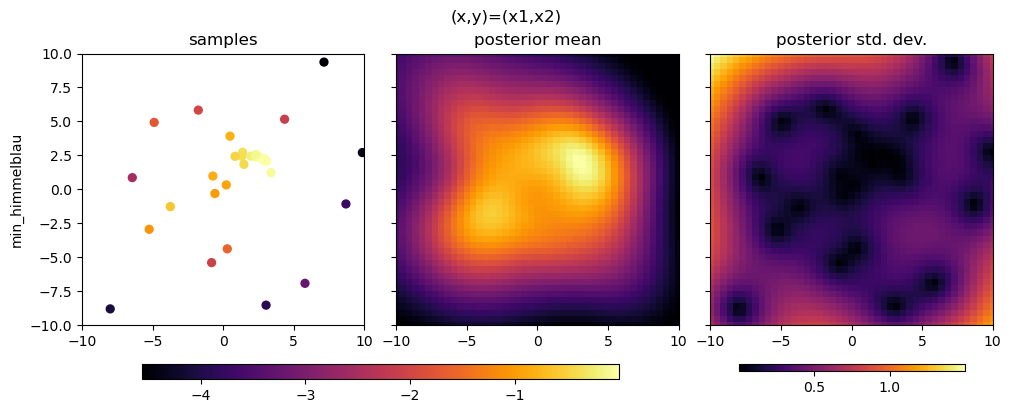

In [9]:
RE(boa.learn(strategy='esti', n_iter=4, n_per_iter=4))
boa.plot_tasks()

Eventually, we reach a point of saturation where no more improvement takes place:

learning with strategy "esti" ...




Transient Scan ID: 7     Time: 2023-06-17 19:14:34
Persistent Unique Scan ID: 'e5a5d82c-513d-48c0-ab47-41004a98a529'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:34.5 |      3.437 |     -0.471 |
|         2 | 19:14:34.6 |      3.247 |      1.825 |
|         3 | 19:14:34.6 |      3.054 |      1.809 |
|         4 | 19:14:34.6 |    -10.000 |     10.000 |
+-----------+------------+------------+------------+
generator list_scan ['e5a5d82c'] (scan num: 7)







Transient Scan ID: 8     Time: 2023-06-17 19:14:36
Persistent Unique Scan ID: '3f0306f1-a59b-46ed-8be6-202882891896'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:36.6 |      3.077 |      1.326 |
|         2 | 19:14:36.6 |      3.368 |      0.671 |
|         3 | 19:14:36.6 |      3.969 |      0.233 |
|         4 | 19:14:36.6 |      3.597 |     -1.923 |
+-----------+------------+------------+------------+
generator list_scan ['3f0306f1'] (scan num: 8)







Transient Scan ID: 9     Time: 2023-06-17 19:14:38
Persistent Unique Scan ID: '03380ead-4f69-4c3a-b584-4912f3845a5f'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:38.8 |      3.376 |     -1.827 |
|         2 | 19:14:38.8 |      3.412 |     -1.610 |
|         3 | 19:14:38.8 |      3.162 |     -1.709 |
|         4 | 19:14:38.8 |    -10.000 |     10.000 |
+-----------+------------+------------+------------+
generator list_scan ['03380ead'] (scan num: 9)







Transient Scan ID: 10     Time: 2023-06-17 19:14:41
Persistent Unique Scan ID: '154cf3bc-5b76-4084-ba9a-acc0c6bed89c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 19:14:41.0 |     -3.073 |      1.499 |
|         2 | 19:14:41.0 |      3.595 |     -1.788 |
|         3 | 19:14:41.0 |      3.748 |     -1.910 |
|         4 | 19:14:41.0 |      3.589 |     -2.013 |
+-----------+------------+------------+------------+
generator list_scan ['154cf3bc'] (scan num: 10)





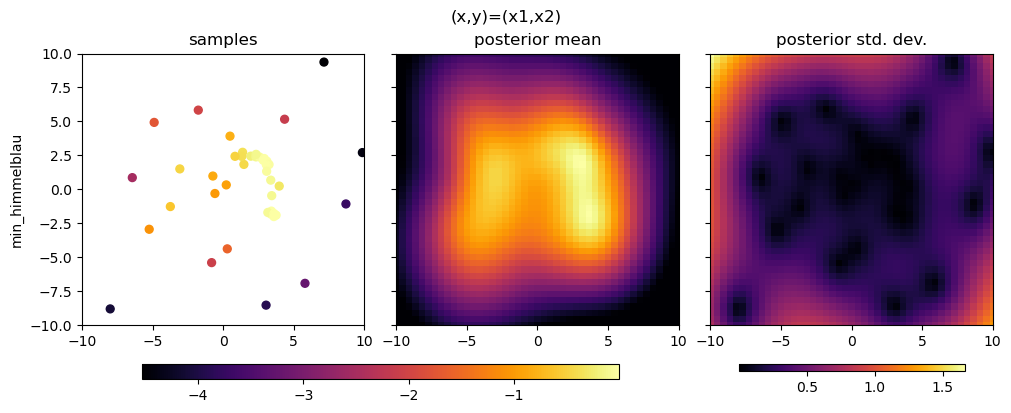

In [10]:
RE(boa.learn(strategy='esti', n_iter=4, n_per_iter=4))
boa.plot_tasks()